If you could see into the high dimensional abstract space of all possible sudoku boards what would it look like? 

![sudokutope teaser image](../images/glimpses-of-the-sudoku-tope-teaser.png)

<!-- END_TEASER -->

I recently made a <a href=http://asymptoticlabs.com/blog/posts/sudoku-satisfiability.html>a post</a> about solving sudoku puzzles by translating them into linear optimization programs and/or boolean satisfiability problems. The "natural" representation of the sudoku puzzle in both cases turned out to be a binary vector with $N^3$ entries. The entries of the vector correspond to whether or not each possible combinations of row, column, and value actually appears in any given board. 

In the case of the linear program optimization the rules of Sudoku translated into a set of linear constraints. Those constraints restricted the space of possible vectors down to a  
<a href=https://en.wikipedia.org/wiki/Polytope>polytope</a> in a lower dimensional subspace. 

I love trying to find good ways to visualize high dimensional objects and this polytope whose vertices are all possible sudoku boards (lets call it the "Sudoku-tope") is too tempting to resist having a little fun visualizing.

First off lets grab some code from that previous sudoku post. 

In [1]:
import numpy as np
import itertools
import scipy.sparse
import copy
import pycosat
import seaborn as sns
import pandas as pd
import sklearn.decomposition

import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "font.size":18,
})

In [3]:
def triplet_to_index(row, col, num, N):
    return int(np.ravel_multi_index((row, col, num), (N, N, N)))


In [4]:
def box_index(row, col, N):
    sqrt_n = int(np.sqrt(N))
    assert sqrt_n**2 == N
    return np.ravel_multi_index((row//sqrt_n, col//sqrt_n), (sqrt_n, sqrt_n))

def generate_uniqueness_sets(N):
    row_sets = [] #one example of each digit in each row
    col_sets= [] #one example of each digit in each col
    box_sets = [] #one example of each digit in each box
    cell_sets = [] #every cell has an assigned number
    
    for row in range(N):
        for col in range(N):
            cell_sets.append([triplet_to_index(row, col, num, N) for num in range(N)])
    
    box_to_pairs = {}
    for num in range(N):
        for i in range(N): #fixed index
            row_set = []
            col_set = []
            for j in range(N): #index we are summing over
                row_set.append(triplet_to_index(i, j, num, N))
                col_set.append(triplet_to_index(j, i, num, N))
                if num == 0:
                    cbox = box_index(i, j, N)
                    box_to_pairs[cbox] = box_to_pairs.get(cbox, []) + [(i, j)]
            row_sets.append(row_set)
            col_sets.append(col_set)

    for num in range(N):
        for box_idx in range(N):
            box_set = []
            row_col_pairs = box_to_pairs[box_idx]
            for row, col in row_col_pairs:
                box_set.append(triplet_to_index(row, col, num, N))
            box_sets.append(box_set)
            
    return row_sets + col_sets + box_sets + cell_sets

def board_to_indicator_variables(arr, as_clause_list=True):
    variables = []
    N = arr.shape[0]
    for row in range(N):
        for col in range(N):
            num = arr[col, row]
            if num >= 0:
                ci = triplet_to_index(row, col, num, N)
                variables.append(ci)
    if as_clause_list:
        variables = [[cvar] for cvar in variables]
    return variables

def board_to_indicator_vector(arr):
    N = arr.shape[0]
    vec = np.zeros(N**3)
    for ci in board_to_indicator_variables(arr, as_clause_list=False):
        vec[ci] = 1.0
    return vec

def indicators_to_board(variables, N):
    shape = (N, N, N)
    rows, cols, nums = np.unravel_index(variables, shape)
    board = -1*np.ones((N, N), dtype=int) #fill with -1
    for r, c, n in zip(rows, cols, nums):
        cval = board[c, r]
        board[c, r] = n
    
    return board

def vector_to_board(vec, threshold=0.5):
    N = int(np.around(np.power(len(vec), 1/3.0)))
    true_vars = np.where(vec > 0.5)[0]
    return indicators_to_board(true_vars, N)

def bsat_to_vector(bsat_solution, N):
    sol = np.array(bsat_solution)
    vec = np.zeros(N**3)
    vec[sol[sol > 0]-1] = 1.0
    return vec
    
def at_least_one_of(variables):
    return [copy.copy(variables)]#copy the variable list to prevent weird in memory modification problems

def at_most_one_of(variables):
    clauses = []
    for i1 in range(len(variables)):
        for i2 in range(i1+1, len(variables)):
            clauses.append([-1*variables[i1], -1*variables[i2]])
    return clauses

def exactly_one_of(variables):
    clauses = at_least_one_of(variables)
    clauses.extend(at_most_one_of(variables))
    return clauses

In [5]:
def to_dense_constraint_matrix(variable_sets, N):
    out_matrix = np.zeros((len(variable_sets), N**3))
    for constraint_index, v_set in enumerate(variable_sets):
        for v_index in v_set:
            out_matrix[constraint_index, v_index] = 1.0
    return out_matrix

# The 4x4 Polytope

There are few enough 4x4 solutions to be able to exhaustively enumerate them without any trouble. To do this we will translate the sudoku rules into a boolean satisfiability problem and then simply use pycosat.itersolve to enumerate all the possible solutions for us.

In [6]:
sudoku_uniqueness_sets_4x4 = generate_uniqueness_sets(4)

In [7]:
shared_clauses = []

for uset in sudoku_uniqueness_sets_4x4:
    shared_clauses.extend(
        exactly_one_of(
            [v+1 for v in uset]
        )
    )

solutions = []

#don't try this for the 9x9 case it will never finish
for sol in pycosat.itersolve(shared_clauses):
    solutions.append(sol)

all_vecs = np.array([bsat_to_vector(bsat, 4) for bsat in solutions])
len(solutions)

288

Before starting to exploit our knowledge of the structure of Sudoku lets start the way I most often start analyzing any high dimensional point cloud and put the points through a principal component transform and take a look at the distribution over the first few principal components.

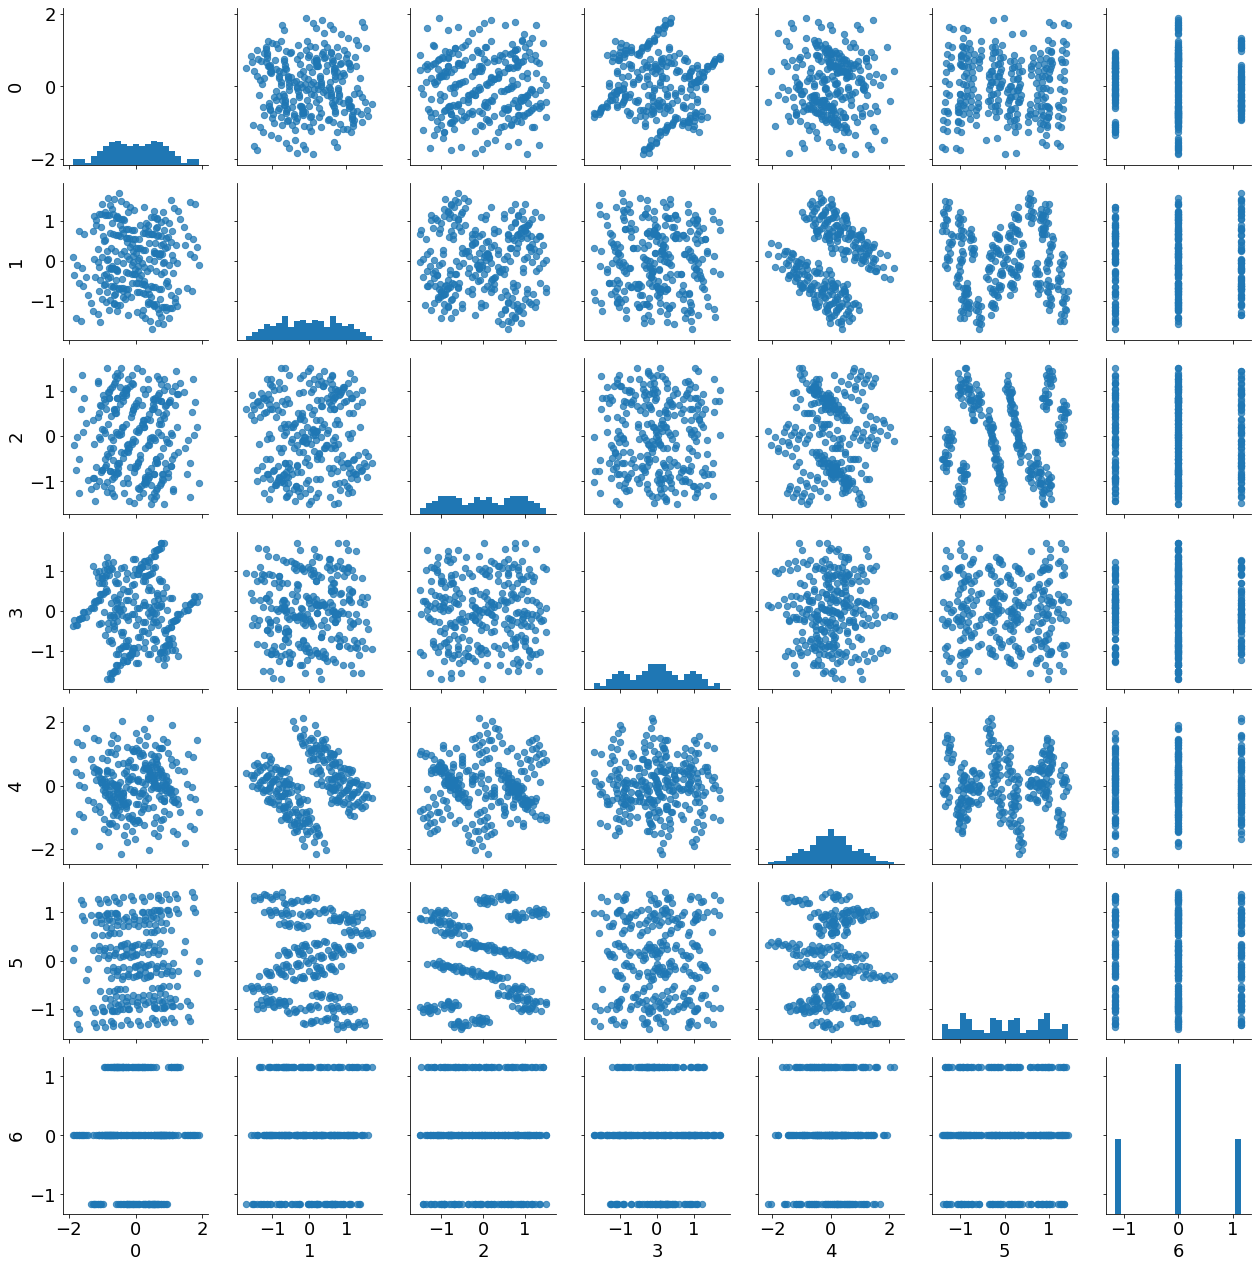

In [78]:
pca4x4 = sklearn.decomposition.PCA().fit(all_vecs)
t = pca4x4.transform(all_vecs)
t_first = t

g = sns.PairGrid(pd.DataFrame(t[:, :7]))
g.map_offdiag(plt.scatter, s=40, alpha=0.75)
g.map_diag(plt.hist, bins=21);

If this reminds you of the random projection visualizations of E8 I did a while back (<a href=http://asymptoticlabs.com/blog/posts/visualizing-lattices.html>see this post</a>) you aren't alone and it isn't entirely a coincidence. I think you certainly get the feeling of looking at some object which clearly exhibits a high degree of structure but looking at that object from weirdly oblique angles (except for that last dimension which seems to be perfectly aligned to some sort of 3 tier separation of the points). 

Why did PCA pick these perspectives in particular? It turns out that this particular set of perspectives has much more with how pycosat enumerated the space of possibilities than PCA "understanding" something special about the point cloud shape. In particular it looks like that last dimension where the set of boards seems to have separated out into three sharp layers seems like it might have latched onto some sort of secret of solution space.

If we take a look at the amount of projected variance along each principal direction we find that it has only 24 non-zero entries, meaning that all the solution points are confined to a 24 dimensional subspace of the full 64 dimensions. Furthermore the projected variance curve as a function of principal component rank consists of just 2 plateaus with no falloff within those plateaus.

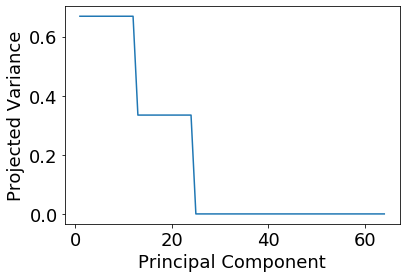

In [9]:
plt.plot(np.arange(1, len(pca4x4.explained_variance_)+1), pca4x4.explained_variance_)
plt.xlabel("Principal Component")
plt.ylabel("Projected Variance");

This is very bad news in terms of using PCA as a tool to pick a set of "special" perspectives for use in visualizations. Normally the set of principal components for a dataset is uniquely defined. The most common definition  of the k-th principal component is the direction of maximum projected variance orthogonal to the first k such directions chosen. Ordinarily one direction will win out over the others (even if the symmetry between the directions is just broken by random noise). It is the size of the difference between the projected variance along each dimension which ensures the uniqueness of the principal vectors. 

But in this case the exactly flat regions of the variance curve are indicating subspaces in which by this metric of projected variance there are absolutely no special directions. Any vector which lies within that subspace is equally good as any other in that respect and so the principal components we actually got are more of an accident of the particular combination of the SVD implementation used to do the calculation and the peculiar ordering of the data rows. In this case the vector ordering actually does have some structure to it since it is tied to the pycosat enumeration algorithm. But that ordering is actually almost entirely what is dictating how PCA has picked the perspectives we see above.

If we apply a random reordering of the data prior to doing the PCA we end up with a completely different set of principal vectors (though the subspaces they span are the same). The resulting projections look much more random and are much more representative of the sort of insights about the shape of the sudoku tope we might hope to glean from PCA by itself. There are definite hints of structure, but exactly what that structure could be is very hard to say.

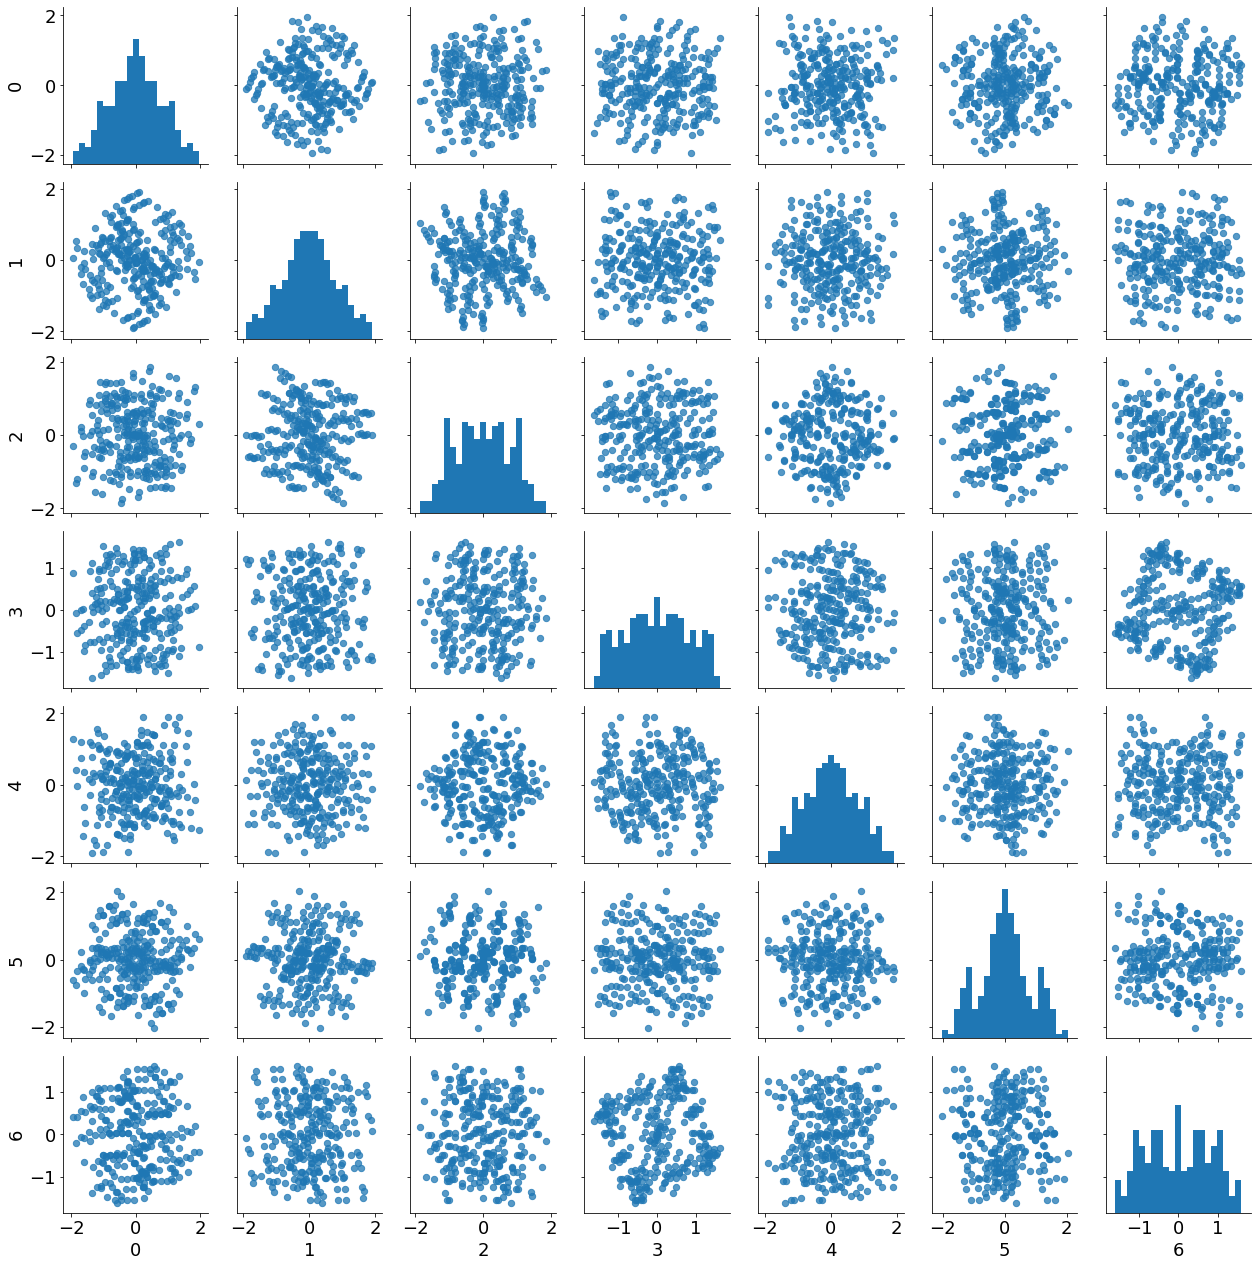

In [10]:
all_vecs = np.array([bsat_to_vector(bsat, 4) for bsat in solutions])

permuted_vecs = all_vecs[np.random.permutation(288)]

pca4x4_perm = sklearn.decomposition.PCA().fit(permuted_vecs)
t = pca4x4_perm.transform(all_vecs)

g = sns.PairGrid(pd.DataFrame(t[:, :7]))
g.map_offdiag(plt.scatter, s=40, alpha=0.75)
g.map_diag(plt.hist, bins=21);

# Broken Symmetry

Later in the post we will try to understand the symmetries of this point cloud and come up with visualizations that exploit that understanding. But achieving deep understanding is hard and if there are cheap tricks we can play to help us getting around having to do that to get good visualizations of our data it makes sense to give them a shot first. 

The reason for the flat projected variance curve is the high degree of symmetry of the space of possible solutions. As we shall see shortly every point in solution space is balanced by other points which can be related to it through the action of a special set of permutation matrices. Usually you aren't working with datasets where many random permutations of the columns you are working with actually leaves you with an identical copy of the very same dataset. This high degree of symmetry means that PCA is having a hard time picking out special directions in data space because from the perspective of how "spread out" the data is along any given dimension there are no special directions. The data is effectively evenly spread in every direction (within the those two 12 dimensional subspaces at any rate).

Is there any way we can break this symmetry and make certain directions have more of the data than others? In a normal real world data set even some amount of noise will break the degeneracy between the amount of variance in different directions in data space. But obviously randomly breaking the symmetries present in our data by adding noise isn't going to help us pick a particularly interesting representation basis for our data.

Well we do in fact know of several "special" directions in data space, namely we know 288 of them in the form of the data points themselves. We can break the symmetry of the whole data set by picking a hand full of these points and giving them a little extra weight by repeating them in the data we feed to PCA. This will make the directions aligned with those particular chosen vectors stand out from the crowd, making those directions unique and ensuring that those points have high magnitude coordinates in the first few principal components of our PCA expansion.

If we pick just a hand full of points to emphasize then those couple of data points serve to align our principal components and we can much more clearly see some interesting structures start to arise (at least compared to the randomly permuted PCA we did above which sould be considered more typical than the view induced by the pycosat ordering). Below I've picked a few points which seemed to give interesting decompositions, though there is no rhyme or reason at this point for why you should pick any particular set of points over another.

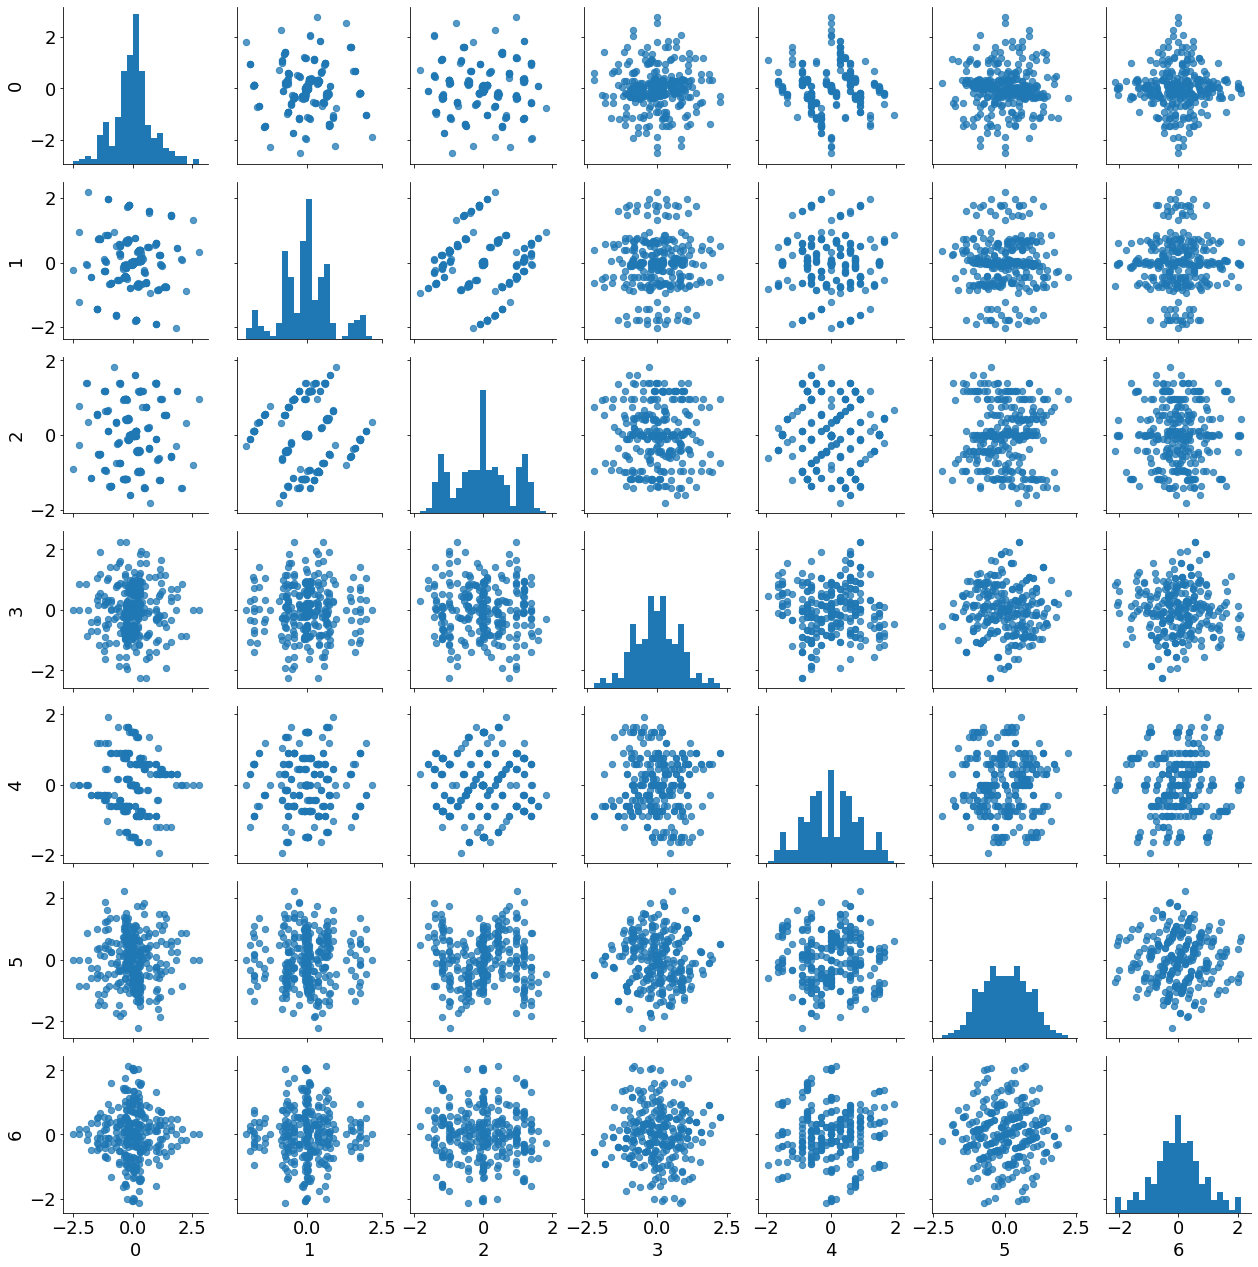

In [11]:
random_idxs = [14, 22, 287]
extra_pts = all_vecs[random_idxs]

pca4x4_broken = sklearn.decomposition.PCA().fit(
    np.vstack([
        all_vecs,
        extra_pts,
    ])
)
t = pca4x4_broken.transform(all_vecs)

g = sns.PairGrid(pd.DataFrame(t[:, :7]))
g.map_offdiag(plt.scatter, s=40, alpha=0.75)
g.map_diag(plt.hist, bins=21);


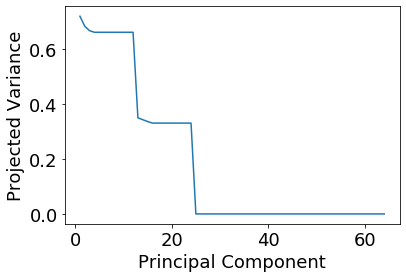

In [12]:
plt.plot(np.arange(1, 4**3+1), pca4x4_broken.explained_variance_)
plt.xlabel("Principal Component")
plt.ylabel("Projected Variance");

As you can see because we only picked 3 points the emphasized dimensions span only 3 of the 12 dimensions and we stil end up wit several dimensions in which the permutation symmetries mean that every possible orthogonal basis is equivalently good from the perspective of a PCA expansion.

We can steepen the variance curve and ensure a unique repeatable expansion which doesn't depend on luck or numerics by picking more random points to use as special directions in our data space. But since we have no systematic way of picking which points to use to break the symmetry and emphasize certain directions over others picking many points instead of just a few points starts to amount to adding random noise to our data.

That random noise does indeed break the degeneracy between different directions but it doesn't help us pick interesting perspectives.

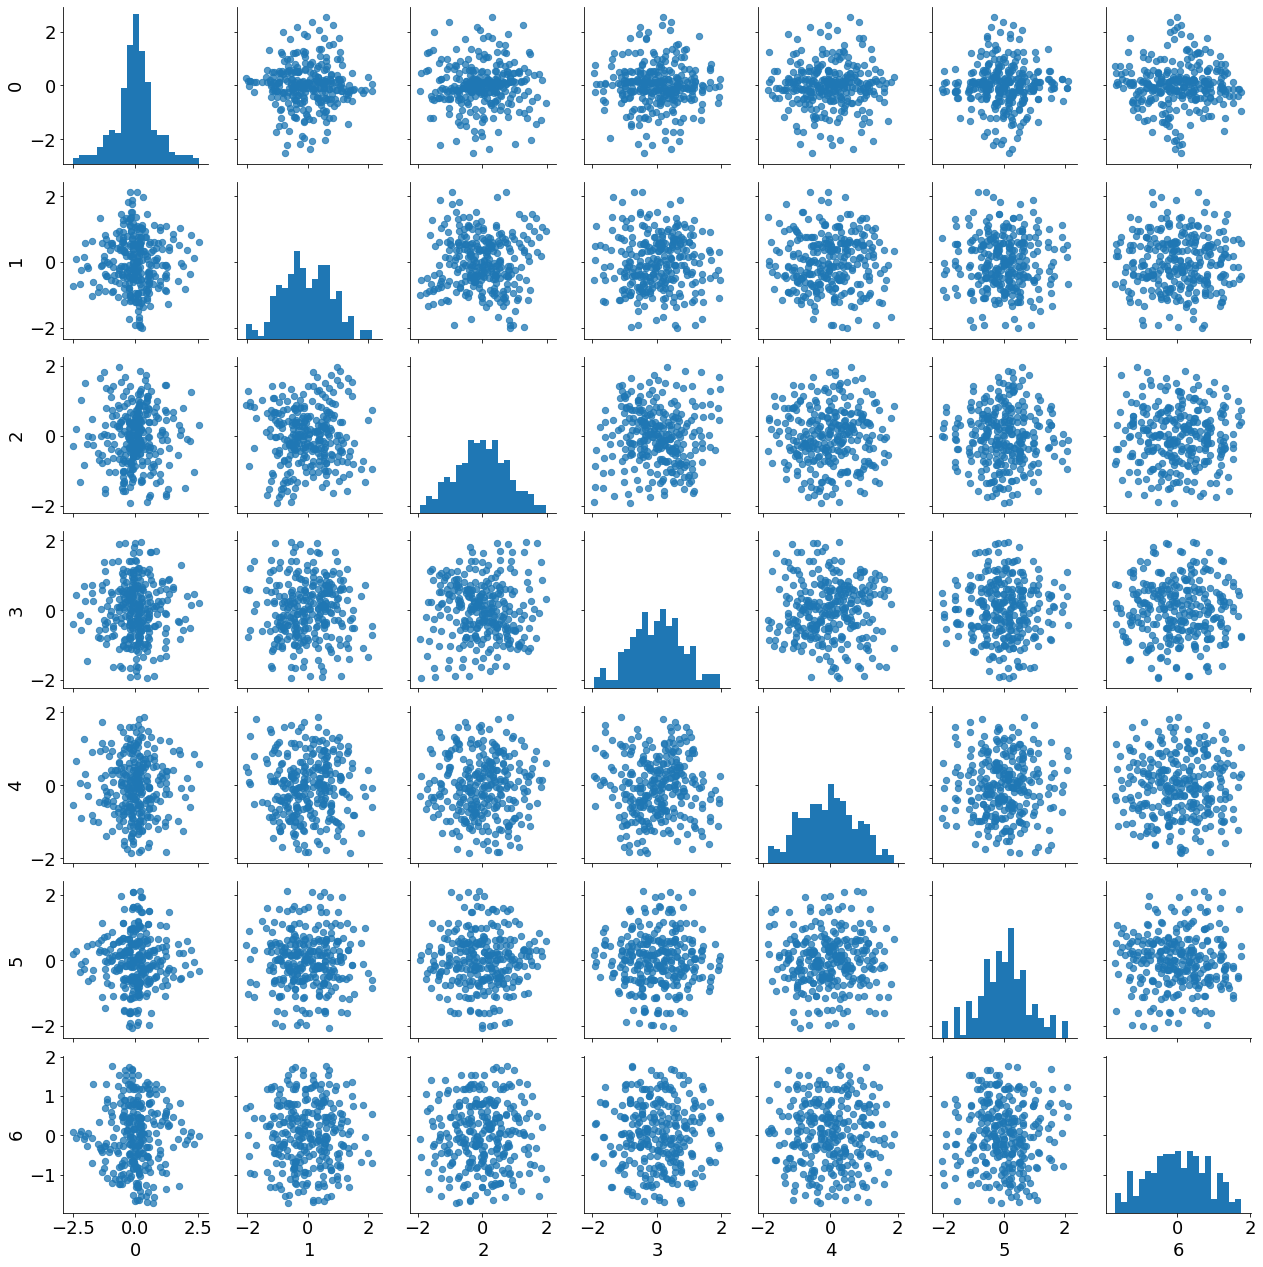

In [13]:
n_extra = 24 #enough to span all the data dimensions

np.random.seed(1234) #pick the same points each time for reproducibility
random_idxs = np.random.permutation(len(all_vecs))[:n_extra]
extra_pts = all_vecs[random_idxs]

pca4x4_broken = sklearn.decomposition.PCA().fit(
    np.vstack([
        all_vecs,
        extra_pts,
    ])
)
t = pca4x4_broken.transform(all_vecs)
#t_extra = pca4x4_broken.transform(extra_pts)

g = sns.PairGrid(pd.DataFrame(t[:, :7]))
g.map_offdiag(plt.scatter, s=40, alpha=0.75)
g.map_diag(plt.hist, bins=21);

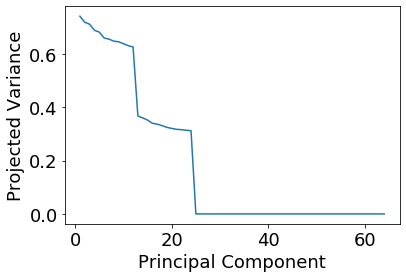

In [14]:
plt.plot(np.arange(1, 4**3+1), pca4x4_broken.explained_variance_)
plt.xlabel("Principal Component")
plt.ylabel("Projected Variance");

This is a really great example of the perturbative stability of a PCA expansion. If the difference in the variance of successive principal components is less than the typical magnitude of the noise variance in your data then your principal components will not be stable the peculiar set of principal component vectors that you do happen to get will be determined just as much by the noise in your data as by the structure of the data it self. 

In this particular special case the successive principal components differ by 0 in their projected variance and so injecting any noise at all can cause arbitrarily large changes to the principal components. In the "broken symmetry" plot above we are using what amounts to about as mild of a perturbation to our data as possible. But the apparent structures we get are completely unrecognizable from each other depending on what particular perturbations we make.  For more normal data sets with more steeply decaying projected variance curves the resulting expansions would be stable up until around the point where the noise in our data start to dominate over the differences in projected variance. This can be a nice thing to keep in mind when trying to interpret principal components and/or deciding how many principal components to keep.

# A Pretty Picture 

Because there are just 288 total solution vectors we can do several things which often don't even occur to me when analyzing most data sets just because they tend to work best on smaller data sets and I usually have a few tens of thousands of data points at a minimum.

But something that can be very effective for small data sets is to just take a look at the raw data itself.

Text(0, 0.5, 'Pycosat Enumeration Order')

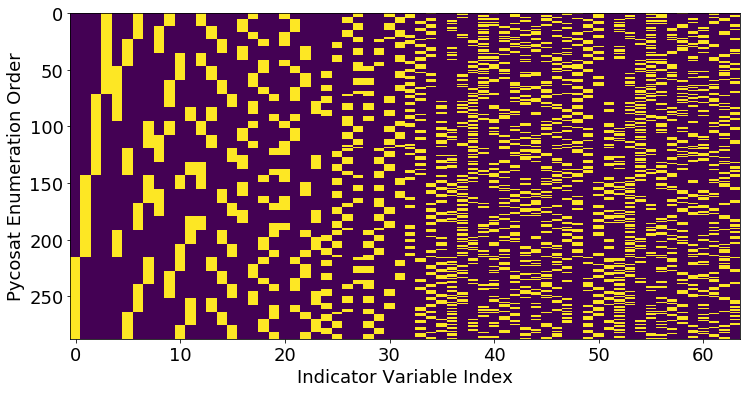

In [121]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(all_vecs, aspect="auto");
plt.xlabel("Indicator Variable Index")
plt.ylabel("Pycosat Enumeration Order")

You can see that the pycosat enumeration ordering is far from random and ended up exploring every possible labeling of the first cell in order which is kind of interesting. The structure controlling the enumeration order of the other rows however seems less than clear. 

There is another way we can view these vectors which is in terms of their (dis)similarity to each other. The easiest way to get a similarity measure on a vector space is to just take a dot product. In this case the dot product between two of our board indicator variable vectors works out to be equal to the number of cells in which those two boards share the same label so it is a nice intuitive measure of similarity. 

Lets take a look at the pairwise similarities between the boards as they were enumerated by pycosat.

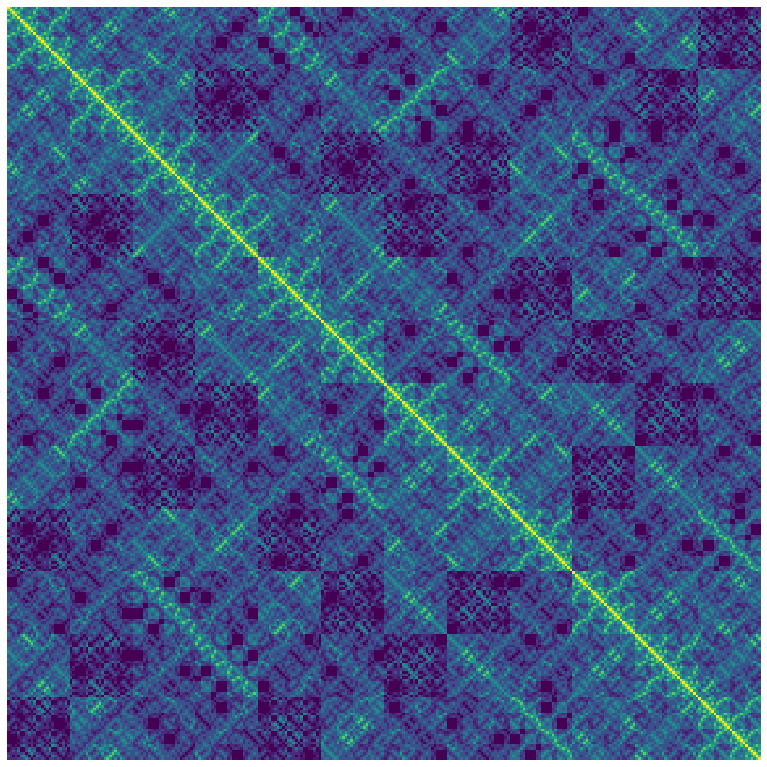

In [136]:
fig, ax = plt.subplots(figsize=(11, 11))

sim_mat = scipy.spatial.distance_matrix(all_vecs, all_vecs)
plt.imshow(np.dot(all_vecs, all_vecs.T), interpolation="nearest")
ax.axis("off");

plt.tight_layout()
plt.savefig("../images/glimpses-of-the-sudoku-tope-teaser.png", )

I've left off the axis labels because I think the resulting plot is art in its own right and I think the axes and labels take away from it. Although this representation might in principle help us to understand something about either pycosat or about sudoku I'm not sure what it is telling us but I think it is beautiful. 

Lest you think that this image would look similar for any sort of enumeration order of the rows that is definitively not the case. Similarity matrices can look dramatically different when you apply a different ordering to the rows and columns even though the same data is being presented in principle. The pycosat ordering above is wonderfully textured and has a sort of fractal appearance. 

Compare this to what we would get from a random enumeration ordering.

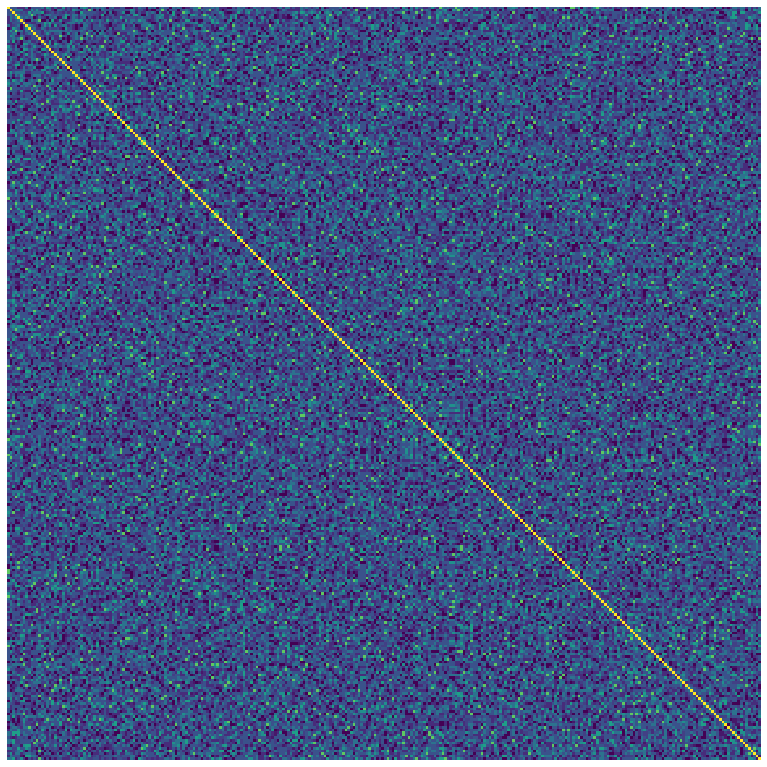

In [109]:
fig, ax = plt.subplots(figsize=(11, 11))
p = np.random.permutation(len(all_vecs)) #random permutation
plt.imshow(np.dot(all_vecs[p], all_vecs[p].T), interpolation="nearest")
ax.axis("off");

plt.tight_layout()

You would be forgiven for thinking that the above resulting similarity matrix was just representing entirely random noise. 

One technique for picking good row/column orderings for data matrices is to do agglomerative hierarchical clustering on the rows. You can then present rows/columns which are close to each other in the cluster tree close together in your data visualization. Seaborn has a nice "clustermap" plotting function for this. 
 
 Lets see how that looks for this similarity matrix.

<Figure size 432x288 with 0 Axes>

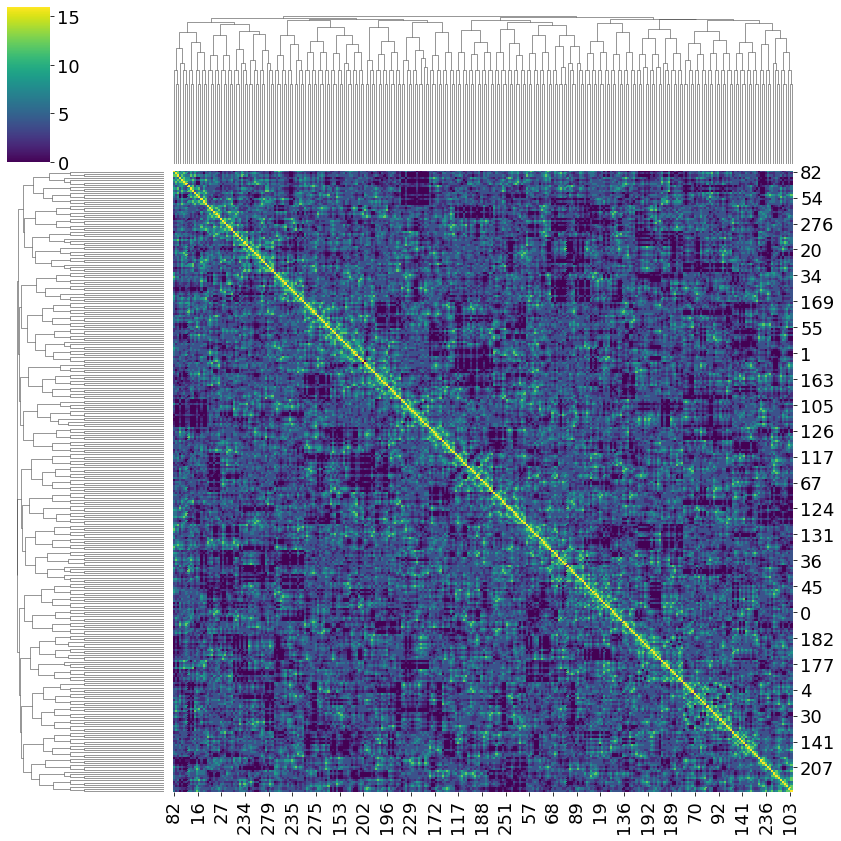

In [115]:
p = np.random.permutation(len(all_vecs)) #random permutation
sim_mat=np.dot(all_vecs[p], all_vecs[p].T)

plt.tight_layout()
sns.clustermap(sim_mat, cmap="viridis", figsize=(12, 12));

Note that the diagonals of the original similarity matrix also got mapped to the diagonal of the clustermap plot. This won't always happen for a clustermap plot on general data because the rows and columns are clustered independently of each other. But for the peculiar case of a similarity matrix where the rows and columns have exactly the same data the clustering will be the same for both and so you happen to get the same ordering for both which means all the data on the diagonal will get remapped to the diagonal again (though not in the same order!).

The agglomerative clustering technique really works best when there are actually clear clusters in the underlying data. In this case the underlying vectors are all equally spread out around their vector space (that is what we can see with the flat projected variance spectrum) and this problem makes clustering the dimensions of the similarity matrix a sort of equally difficult problem, just about any sort of clustering is nearly as good as any other and so we don't end up with any clear structure coming to the fore. 

But other orderings of our data give really beautiful results here and I can't help but share a few more such visualizations, just for fun.

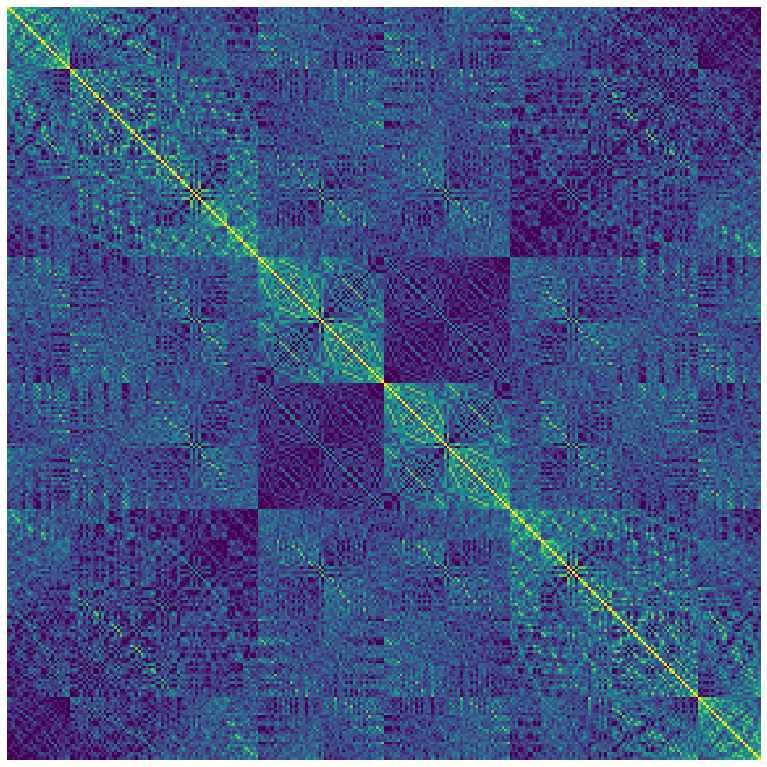

In [126]:
fig, ax = plt.subplots(figsize=(11, 11))
p = np.argsort(t_first[:, 5])
plt.imshow(np.dot(all_vecs[p], all_vecs[p].T), interpolation="nearest")
ax.axis("off");
plt.tight_layout()


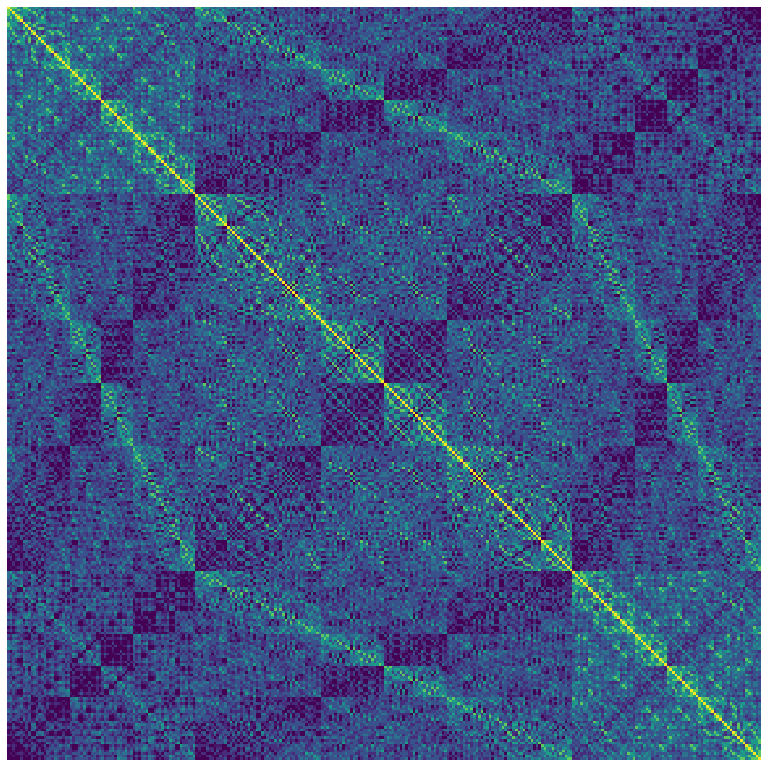

In [127]:
fig, ax = plt.subplots(figsize=(11, 11))
#p = np.random.permutation(len(all_vecs))
p = np.argsort(t_first[:, 6]+0.2*t_first[:, 5])
plt.imshow(np.dot(all_vecs[p], all_vecs[p].T), interpolation="nearest")
ax.axis("off");

plt.tight_layout()

# Board Symmetries 

Ok, It took a little bit longer than I anticipated to get here but now we can dig in to using our knowledge about sudoku specifically to help us get better representations of the underlying data structure.
 
I mentioned earlier that the reason for the flat variance curves for our PCA expansions is that the data is invariant to certain special permutations of our columns. These permutations are expressions of particular kinds of "symmetries" of Sudoku. I will use the language of <a href=https://www.hindawi.com/journals/ijcom/2012/760310/>this paper</a> and refer to columns of mini-grids as "stacks" and rows of mini-grids as "bands". One possible symmetry group of sudoku boards can then be defined in terms of combinations of the follwowing sorts of operations. 

* Any permutation of labels (e.g. replacing 3 with 5 everywhere)
* Any permutation of columns within the same vertical stack (e.g. swapping the first and second column)
* Any permutation of stacks (e.g. swapping columns 1 through $\sqrt{N}$ with columns $\sqrt{N}+1$ through $2 \sqrt{N}$)
* Any permutation of rows within the same horizontal band
* Any permutation of horizontal bands 

A "symmetry" of an object is something you can do to that object which leaves the object unchanged, or to put it a slightly different way an object is invariant under its own symmetry transforms. So for example rotating a square by any multiple of 90 degrees is a symmetry of the square, but rotating by 45 degrees is not. Different objects will have different sorts of symmetries and every transformation which leaves the object invariant can be considered a symmetry of that object.

Any one sudoku board is definitely altered by carrying out any of these transformations, so in what sense can they be considered to be symmetries of Sudoku? Well notice that each of these transformations is also obviously invertible. That means that if we apply one of these transforms to every board in the set of all possible boards we must end up with the same set of boards again. If some boards were missing then that would mean that some of these transformations are not completely invertible because we must have transformed two or more boards onto the same output board. But obviously all these transformations are invertible since their inverse is to just apply the appropriate inverse permutation. Thus the set of all possible boards is left invariant under any of these transforms and so these are indeed symmetries of the set of all possible Sudoku boards. 

# Other Symmetries?

This raises a couple of questions.

* Do the above transformations and their combinations constitute all possible symmetries of the set of all sudoku boards?
* Do all these symmetries have a goemetrical interpretation in terms of rotations of the sudoku polytope?
* What are all the rotational symmetries of the sudoku polytope?

## Geometrical Symmetries vs Symmetries of an Abstract Set 

To answer the first question. If we are following the above definition of a symmetry as being any transformation which leaves an object invariant then definitely there are many other "symmetries" of the set of all boards. Any invertible function of whose domain and image is the set of all boards constitutes a "symmetry" by this definition. But by this definition absolutely any random permutation of boards would then constitute "symmetry" transformation. That definitely doesn't seem very "symmetric" to me. But if we go by this definition of symmetry then there are innumerable other "symmetries" which we did not ennumerate above, most of which wouldn't have any particular rhyme or reason, they are just random mappings of the set of boards onto itself.

The reason that every possible permutation of boards is a "symmetry" of the set of boards is because interpretation of the bords as a set has no geometrical structure. And of course the symmetry group of a structureless set of elements is by definition the <a href=https://en.wikipedia.org/wiki/Symmetric_group>symmetric group</a> which is just the group of all permutations of elements in a set (or equivalently the group of all mappings of a set onto itself). 

But this blog post is all about the geometry of the polytope of sudoku board indicator variables interpreted as members of $\mathbb{R}^{N^3}$ 
What we really want to know is what is the spatial <a href=https://en.wikipedia.org/wiki/Symmetry_group>symmetry group</a> of the sudoku polytope interpreted as a geometrical object. We therefore are only interested in mappings of the set of boards onto itself which can be interpreted as a geometrical transformation of the vector space in which the solution points are embedded. 

Many but not all permutations of a set of points can be interpreted as a spatial transformation. The particular set of point permutations which are also spatial symmetries is determined by the properties of the set of points in question. Any two points in space can be mapped onto each other by reflection over a mid point and so the symmetry group of every 2 point set is isomorphic to the permutation group on 2 symbols. A randomly distributed cloud of many points isn't symmetric at all and won't be able to be mapped onto itself in any way except the identity transform so its symmetry group will just be the group consisting of just the identity transform (or equivalently the permutation group on 1 element). 

As a slightly less trivial example take the symmetries of a square. A square has 4 vertex points which means its spatial symmetries must be isomorphic to a subgroup of the permutation group for 4 symbols (since all symmetries of the square are mappings of those 4 points onto themselves). The permutation group on 4 symbols contains $24=4*3*2$ possible permutations. But there are only 4 achievable permutations if we restrict ourselves only to permutations which are interpretable as rotations within the plane. If we also allow reflections in the plane or allow the points to be rotated in 3 dimensions then we can also achieve the effects of the three "flipping" motions flipping the square horizontally, vertically or diagonally. Which brings us to $3*4=12$ of the 24 possible vertex permutations. Can we get the last factor of 2 by bumping ourselves up into the 4th dimension for rotations? 

No, no matter what sort of distance preserving transformation we apply to the square we can never turn the two farthest corners of the square into adjacent corners of the square. That transformation would in effect twist two edges of the square in opposite directions. This would not be a distance preserving transformation and so doesn't  represent a symmetry of the square. To see this suppose our original square was labeled 1,2,3,4 running around the outside of the square clockwise. Each adjacent digit represents a short edge of the square and labels 2 apart in this labeling represent the far edges of the square. Any distance preserving transformation clearly cannot turn the shorter edges of the square into the longer diagonals of the square. So for example if after we have applied our transformation we find a set of labels which read 1,3,4,2 we know we have messed up somewhere along the way, since now 1 and 3 are connected by a short edge whereas before they were on opposite corners.
So no matter what dimension the square is embedded in the group of rotational symmetries of the square is restricted to a 12 element subgroup of the full 24 element permutation group of its vertexes.  

## Label Permutations are Rotational  Symmetries of the Polytope

This brings us back to the second question on the list above. Are all of the symmetries of boards we discussed in the previous section rotational symmetries of the sudoku polytope? The answer here turns out to be yes. The above transformations are different sorts of permutations. Either permutations over the labels in the cells or permutation over the labels of the rows and columns. Because of the particular way we have chosen to encode sudoku boards as indicator vectors all permutations over labels of any sort, be they rows, columns, or digits can be interpreted as a permutation over the idexes of the vector. Permutation matrices are a subset of the general set of unitary matrices (which are matrices with determinant $\pm 1$). You can think of unitary matrices as being the higher dimensional analogs of rotation operators. So all such transformations are distance preserving. Which means that the above row/column/value relabeling operations do indeed represent geometrical symmetries of our polytope! 

## All the Symmetries?

Now to tackle the third question. Does this constitute all possible rotational symmetries of the polytope? 

The answer turns out to be no. In the above transformations I have left out several "obvious" symmetries; the rotational and reflectional symmetries of a square. Originally I just sort of assumed that the row and column permutations would naturally also include the rotational and reflectional symmetries but it turns out that although vertical and horizontal reflection are indeed something that can be built up out of the previously mentioned permutations, reflection over the diagonals of the matrix cannot be. Something I would have missed but which you can readily find by reading the things you find when you search the web for information about the sudoku symmetry group.

Once you include the matrix transposition operation you achieve the group which is most often talked about as being "the" sudoku symmetry group. But although I have seen this group invoked several places I haven't found any sort of proof that this symmetry group is the maximal such symmetry group. This really isn't a surprise since all the other resources I have found are considering the set of valid solution boards as an abstract set and not as a geometrical object. Seen from that perspective any subgroup of the permutation group on a number of elements equal to the number of possible sudoku solutions would constitute a "symmetry" of the set of solutions in some way. But the corresponding permutations may not have a nice humanly understandable explanation like the row and column or relabeling operations mentioned above. But proving that they cannot have a humanly understandable explanation seems impossible. 

But this post is concerned with the sudoku polytope taken as a very specific geometric object and the set of rotational symmetries of that geometric object is a well defined thing even if it is difficult to analyze. We now know that the transformations which are normally taken to constitute the sudoku symmetry group are a subgroup of the rotational symmetry group of the sudoku-tope. But is that subgroup equal to the full group or are there more elements in it?

To be totally honest I can't really think of a good way to tackle this question in its full generality. Could there be unitary matrices out there that have fractional entries which leave the set of solution vectors invariant? Maybe? 

This feels like a really interesting question to try and tackle but my initial attempts didn't lead me anywhere and this post will already be quite long without tacking this extra wrinkle. So for the moment I will lay this aside and perhaps someday I will come back to it. 

## Label Permutation Symmetry

Lets start with the label permutation symmetry and use it to split the visualization of the structure into the visualization of the label permutation symmetry itself and the visualization of a skeleton of boards that cannot be transformed into one another just through relabeling. If we pick the skeleton of solution vectors such that only one exemplar from the set of boards which can be related to each other by relabeling is in the skeleton then we can recover the full set of all possible solution boards by rotating that skeleton of points by the associated relabeling rotation matrices. 

Each point in the skeleton will map out the same "shape" induced by the relabeling symmetry so it suffices to just visualize the shape that a single point traces out under the action of the relabeling group.

Enumerating all these rotation matrices is straightforward.

In [137]:
def generate_label_permutation_transforms(N):
    transform_matrices = []
    for permutation in itertools.permutations(range(N)):
        target_indexes, source_indexes = [], []
        for board_row in range(N):
            for board_col in range(N):
                for orig_num, new_num in enumerate(permutation):
                    orig_idx = triplet_to_index(row=board_row, col=board_col, num=orig_num, N=N)
                    new_idx = triplet_to_index(row=board_row, col=board_col, num=new_num, N=N)
                    target_indexes.append(new_idx)
                    source_indexes.append(orig_idx)
        transform = scipy.sparse.coo_matrix(
            (
                np.ones(len(target_indexes)),
                (
                    target_indexes,
                    source_indexes,
                ),
            ),
            shape=(N**3, N**3),
        )
        transform_matrices.append(transform)
    
    return transform_matrices


In [138]:
label_transforms = generate_label_permutation_transforms(4)

In [140]:
transformed_pts = []

for t_mat in label_transforms:
    #take just the first point and apply all the rotations to it.
    transformed_pts.append(t_mat*all_vecs[0])


In [148]:
pca_lsym = sklearn.decomposition.PCA().fit(transformed_pts)

before we take a look at the scatter grid for these points lets take a look at the explained variance curve. There are $4!=24$ elements in the label permutation group and so we have a dataset of 24 points. We know from the above PCA expansions of the full set of points that the full set of 288 vectors spans a subspace of 24 dimensions and so in principle we might expect that the label permutation rotations could explore the full dimension of that subspace. 

But when we take a look we find that actually the label permutation structure is just 9 dimensional. Furthermore the variance curve is exactly flat in all 9 dimensions.

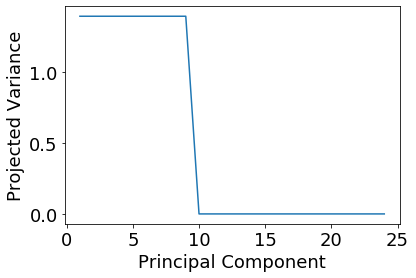

In [150]:
plt.plot(np.arange(1, len(pca_lsym.explained_variance_)+1) , pca_lsym.explained_variance_)
plt.xlabel("Principal Component")
plt.ylabel("Projected Variance");

If we now take a look at the scatter plot grid of these 24 points we can see that the resulting scatter plots aren't uncovering much structure. This is because of the flatness of the variance curve. Just as before in the two 12 dimensional subspaces with equal projected variance there is no way to pick out special directions and so the perspectives that the  PCA expansion ends up picking are indistinguishable from a random set of projections.

It is precisely this lack of special directions in vector space that make the above scatter plots of the full space look so disorderly. So it isn't really any surprise that when we have isolated a key reason that the projected variance is flat we would have trouble picking good perspectives for viewing the 9 dimensional polytope induced by the label rotation group whatever it looks like.

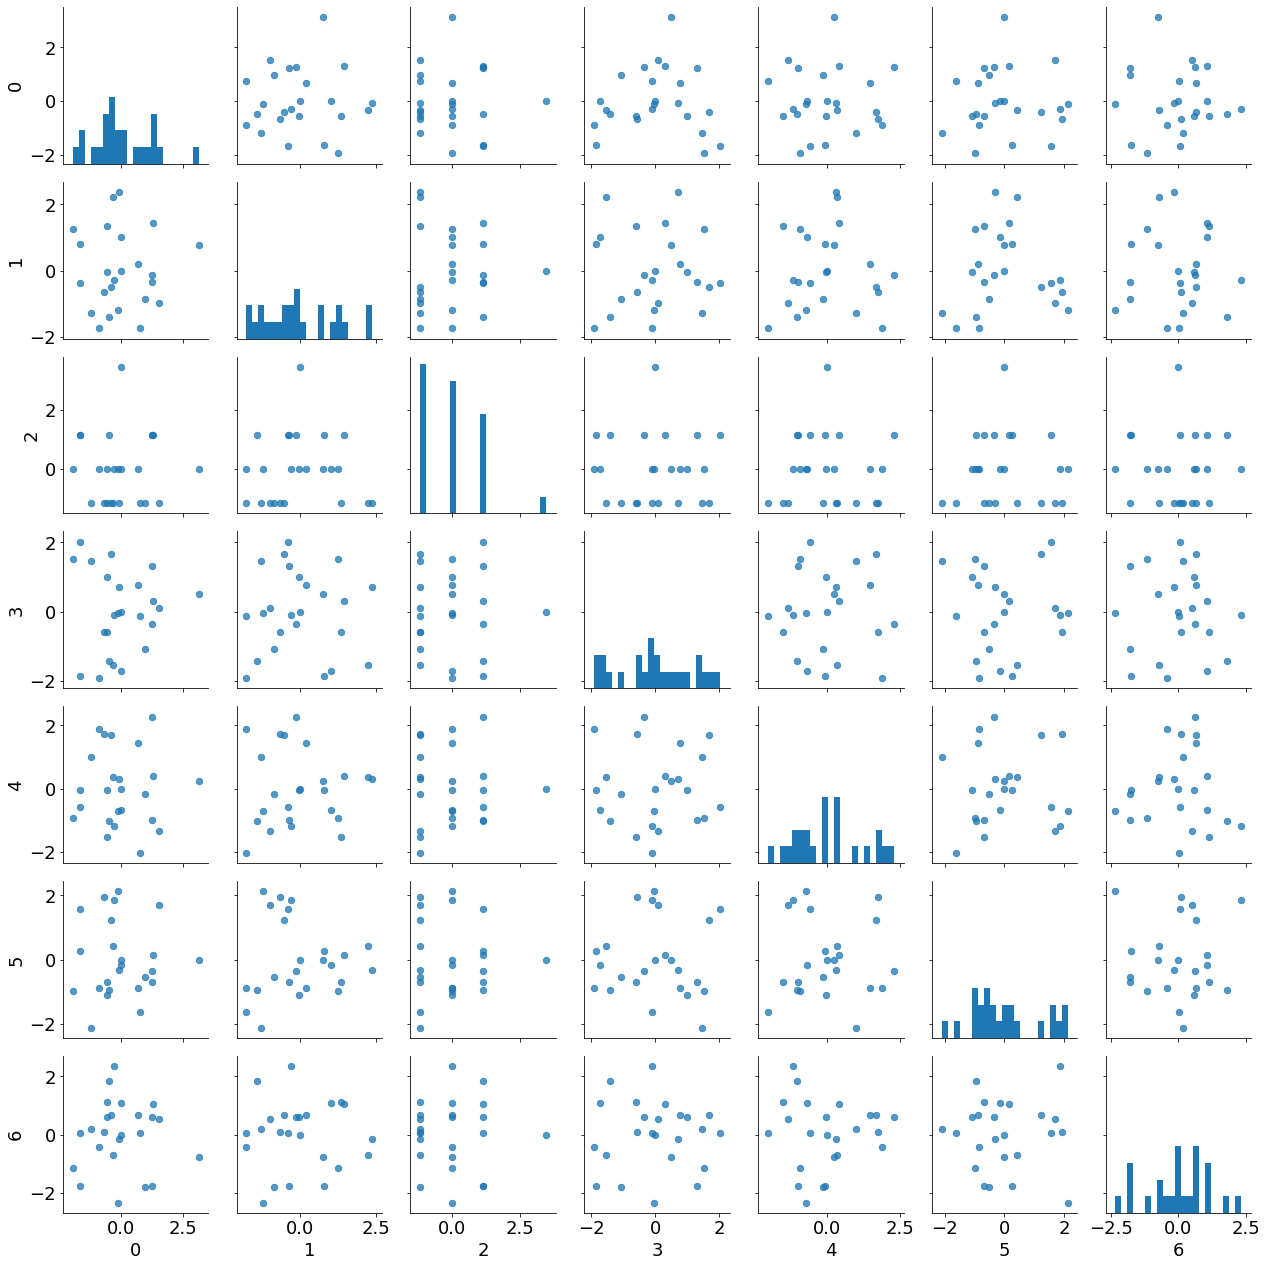

In [155]:
t = pca_lsym.transform(transformed_pts)
g = sns.PairGrid(pd.DataFrame(t[:, :7]))
g.map_offdiag(plt.scatter, s=40, alpha=0.75)
g.map_diag(plt.hist, bins=21)

# Visualizing The Symmetry Reduced Skeleton

Trying to visualize the "shape" of the label permutation symmetry itself didn't give great results but if we get rid of the permutation symmetry and take a look at the distribution of the skeleton that is left behind can PCA do a better job of finding interesting structures?

Also how do we find a subset of solutions which cannot be mapped onto each other by label permutation? The easy way to do that is to just fix the labels in the upper left grid. We can add those labels as a set of constraints and again enumerate all possible boards.

Since there are 24 possible relabelings we end up with 288/24 = 12 solutions in the restricted subset.

In [164]:
board_archetype = -1*np.ones((4, 4), dtype=int)
board_archetype[0, 0] = 0
board_archetype[0, 1] = 1
board_archetype[1, 0] = 2
board_archetype[1, 1] = 3

In [166]:
restriction_clauses = [
    [var+1] 
    for var in board_to_indicator_variables(board_archetype, as_clause_list=False)
]

In [169]:
restricted_solutions = []

#don't try this for the 9x9 case it will never finish
for sol in pycosat.itersolve(
    shared_clauses + restriction_clauses
):
    restricted_solutions.append(sol)

restricted_vecs = np.array([bsat_to_vector(bsat, 4) for bsat in restricted_solutions])
len(restricted_vecs)

12

In [172]:
pca_restricted = sklearn.decomposition.PCA().fit(restricted_vecs)

Again lets first take a look at the projected variance curves. Before we take a look at the scatter grid. We have 12 points and could in principle therefore have up to 12 dimensions in the resulting point cloud but we turn out to have all 12 points living on a 7 dimensional subspace. Furthermore there are 3 distinct linear subspaces with flat projected variance within those subspaces. Two of those subspaces are 2 dimensional and one is 3 dimensional. 

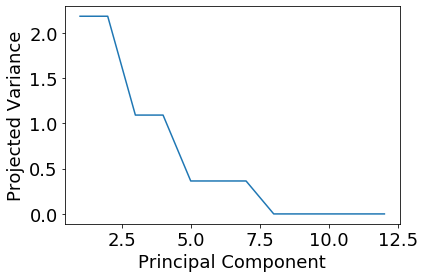

In [173]:
plt.plot(np.arange(1, len(pca_restricted.explained_variance_)+1) , pca_restricted.explained_variance_)
plt.xlabel("Principal Component")
plt.ylabel("Projected Variance");

Although the projected variance is flat and therefore the perspectives within those subpaces will be arbitrary our scatter plots are also 2 dimensional and so the particular 2 dimensional perspectives chosen by PCA are actually unique! Though any arbitrary rotation within those 2D scatter plot planes would technically also serve as a PCA expansion. 

You may be interested to know that there turn out to be 3 effectively different 4x4 sudoku grids under the symmetry transforms mentioned in this post. Those 3 plateaus in the variance curves for the 12 restricted grid I think also correspond to those 3 effectively different solutions but haven't actually checked that is the case. 

Lets take a look at the scatter grid of these 12 points and see if we get any better sense of the shape they trace out in 7 dimensions.

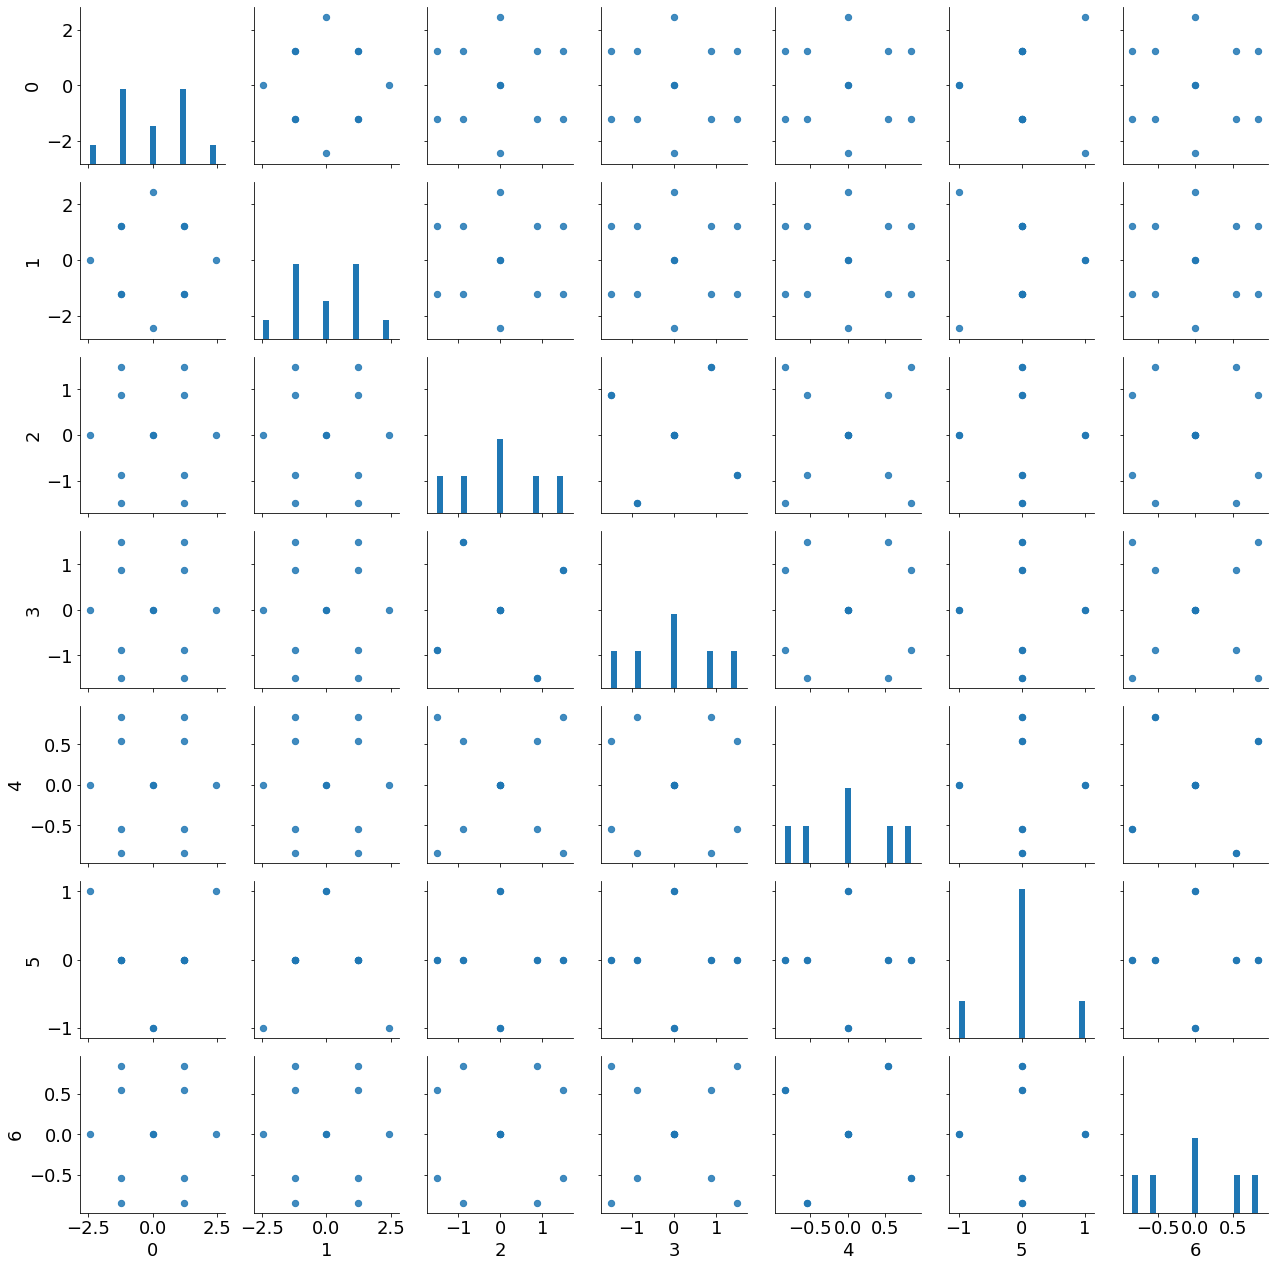

In [182]:
t = pca_restricted.transform(restricted_vecs)

g = sns.PairGrid(pd.DataFrame(t[:, :7]))
g.map_offdiag(plt.scatter, s=40, alpha=0.85)
g.map_diag(plt.hist, bins=21);


For a dataset of just 12 points it is hard to think of how you might be able to get a more interesting mixture of different resulting shapes in different perspectives. I think the result looks really quite crystalline. 

# Final Thoughts

The visualization of the solutions of the 4x4 case was originally just supposed to be a warmup for tackling the much much larger space of 9x9 solutions. But the 4x4 space turned out to be much richer and more interesting than I would have expected and the project ballooned into quite a large post by itself. I may yet come back to this and try and tackle the visualization of the 9x9 polytope but if I do it will be in a separate post. Even just the enumeration of all 5 billion effcetively different 9x9 solution boards would be quite a chore and calculating density maps for different 2D projections would be fun but would take a lot of computer time and there is no way to know whether or not I would end up being able to see anything interesting there. Most likely if I ever do return to this I will just pick some small corner of solution space which I can easily enumerate completely (perhaps a few million boards at most) and see if I can eek out some interesting visualizations of the 2D marginals somehow, or even perhaps do a much expanded version of the similarity matrices that turned out to be so beautiful in the 4x4 case.